Baseline on SNLI tested on ANLI parsed for 'reasoning'

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
!pip install datasets
from datasets import Dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/experiments_data/

Mounted at /content/drive
adversarial_data.csv		  high_level_phenomena.csv	small_snli_test_1.5k.csv
adversarial_data_final.csv	  logs				small_snli_test_3k.csv
adversarial_predictions.csv	  low_level_phenomena.csv	small_snli_train_15k.csv
adversarial_predictions_test.csv  model				small_snli_train_20k.csv
baseline_model_output		  model_output			snli_1.0_dev.txt
distilbert_baseline_snli_output   model_outputs			snli_1.0_test.txt
distilbert_output		  multinli_1.0_dev_matched.csv	snli_dev.csv
filtered_for_reasoning.csv	  multinli_1.0_train.csv	snli_test.csv
final_adversarial_data.csv	  small_snli_dev_1.5k.csv	snli_train.csv
final_baseline_model_output	  small_snli_dev_3k.csv


In [ ]:
def prepare_dataframe(file_path):
    df = pd.read_csv(file_path)
    print(f"Initial DataFrame from {file_path}:\n")
    print(df.head())

    df['input_text'] = df['sentence1'] + " [SEP] " + df['sentence2']
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
    df['label'] = df['gold_label'].map(label_mapping)
    df = df[['input_text', 'label']].dropna()

    print("\nDataFrame after processing:\n")
    print(df.head())

    return df

In [ ]:
#saved model and tokenizer
model_path = "/content/drive/MyDrive/experiments_data/model_outputs/distilbert_snli_baseline/final_baseline_saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

print("\nTokenizer and model loaded successfully.")


Tokenizer and model loaded successfully.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True)

In [ ]:
#ANLI
adversarial_test_path = '/content/drive/MyDrive/experiments_data/filtered_for_reasoning.csv'
df_adversarial_test = prepare_dataframe(adversarial_test_path)
print("\nProcessed Adversarial Test DataFrame head:")
print(df_adversarial_test.head())
adversarial_test_dataset = Dataset.from_pandas(df_adversarial_test)
adversarial_test_dataset = adversarial_test_dataset.map(tokenize_function, batched=True)
adversarial_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Initial DataFrame from /content/drive/MyDrive/experiments_data/filtered_for_reasoning.csv:

                                           sentence1  \
0  Homebrew is a free and open-source software pa...   
1  The Yankees split Hollywood with something to ...   
2  Manchester United Football Club is an English ...   
3  Natalie Anne Merchant (born October 26, 1963) ...   
4  Hendrik Antoon Lorentz (18 July 1853 â€“ 4 Feb...   

                                           sentence2     gold_label  
0                            Homebrew costs nothing.        neutral  
1  The Yankees have lost games by less than two p...        neutral  
2  Some called Manchester United by the name Newt...     entailment  
3  Natalie Anne Merchant is known for drowning ki...  contradiction  
4   The theoretical explanation is named for Zeeman   contradiction  

DataFrame after processing:

                                          input_text  label
0  Homebrew is a free and open-source software pa...      0
1

Map:   0%|          | 0/226 [00:00<?, ? examples/s]


Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.45      0.75      0.56       102
contradiction       0.38      0.18      0.24        74
   entailment       0.32      0.14      0.19        50

     accuracy                           0.42       226
    macro avg       0.38      0.35      0.33       226
 weighted avg       0.40      0.42      0.37       226


Overall Confusion Matrix:


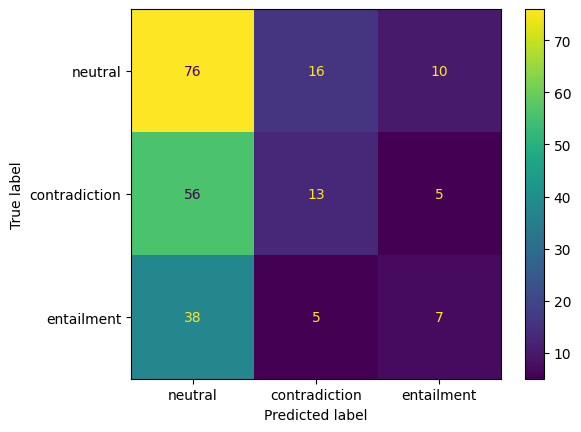


Predictions saved to /content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/anli_reasoning_predictions_.csv


In [ ]:
def evaluate_with_phenomena(trainer, dataset, label_list, output_csv="predictions_output.csv"):
    predictions, labels, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=1)

    print("\nOverall Classification Report:")
    print(classification_report(labels, pred_labels, target_names=label_list))

    cf_matrix = confusion_matrix(labels, pred_labels)
    print("\nOverall Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_list).plot()
    plt.show()

    dataset_df = pd.DataFrame({
        'input_text': dataset['input_text'],
        'true_label': labels,
        'predicted_label': pred_labels
    })


    reverse_label_mapping = {0: "neutral", 1: "contradiction", 2: "entailment"}
    dataset_df['true_label'] = dataset_df['true_label'].map(reverse_label_mapping)
    dataset_df['predicted_label'] = dataset_df['predicted_label'].map(reverse_label_mapping)

    dataset_df.to_csv(output_csv, index=False)
    print(f"\nPredictions saved to {output_csv}")

output_csv_path = "/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/anli_reasoning_predictions_.csv"
evaluate_with_phenomena(trainer, adversarial_test_dataset, label_list, output_csv=output_csv_path)
